In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
# load .mat data with expected structure

in_file = '/home/filip/ramAIn/datasets/dataset - pro statistické vyhodnocení/prep/Scan_049_Spec.Data 1_F.mat'
mdict = {}
matlab_data = scipy.io.loadmat(in_file, mdict=mdict)

name = list(mdict)[-1]
matlab_data = matlab_data[name][0, 0]

data = matlab_data[7]

map_shape1 = tuple(matlab_data[5][0])
x_axis1 = matlab_data[9][1][0][0]
data1 = np.reshape(data, (map_shape1[1], map_shape1[0], -1))

In [2]:
in_file = '/home/filip/ramAIn/datasets/dataset - pro statistické vyhodnocení/prep/Scan_042_Spec.Data 1_F.mat'
mdict = {}
matlab_data = scipy.io.loadmat(in_file, mdict=mdict)

name = list(mdict)[-1]
matlab_data = matlab_data[name][0, 0]

data = matlab_data[7]

map_shape2 = tuple(matlab_data[5][0])
x_axis2 = matlab_data[9][1][0][0]
data2 = np.reshape(data, (map_shape2[1], map_shape2[0], -1))

In [3]:
in_file = '/home/filip/ramAIn/datasets/dataset - pro statistické vyhodnocení/prep/Scan_043_Spec.Data 1_F.mat'
mdict = {}
matlab_data = scipy.io.loadmat(in_file, mdict=mdict)

name = list(mdict)[-1]
matlab_data = matlab_data[name][0, 0]

data = matlab_data[7]

map_shape3 = tuple(matlab_data[5][0])
x_axis3 = matlab_data[9][1][0][0]
data3 = np.reshape(data, (map_shape3[1], map_shape3[0], -1))

In [4]:
data4 = np.ones_like(data3)
data4[:, :] = data1[0, 0]

In [37]:
in_file = '/home/filip/ramAIn/data/Gefionella_processed.mat'
mdict = {}
matlab_data = scipy.io.loadmat(in_file, mdict=mdict)

name = list(mdict)[-1]
matlab_data = matlab_data[name][0, 0]

data = matlab_data[7]

map_shape5 = tuple(matlab_data[5][0])
x_axis5 = matlab_data[9][1][0][0]
data5 = np.reshape(data, (map_shape5[1], map_shape5[0], -1))

In [38]:
print(x_axis1, x_axis2, x_axis3)
# TODO jeste potrebujeme predtim zajistit, ze jsou osy x stejne oprevdu a mame vsude stejne dat

[ 401.27882108  404.10823509  406.93666355 ... 3820.42566954 3822.22770441
 3824.02928456] [ 401.27882108  404.10823509  406.93666355 ... 3820.42566954 3822.22770441
 3824.02928456] [ 401.27882108  404.10823509  406.93666355 ... 3820.42566954 3822.22770441
 3824.02928456]


In [39]:
# make common x axes and vals
x_axes = [x_axis1, x_axis2, x_axis3, x_axis3, x_axis5]
dataset = [data1, data2, data3, data4, data5]

# find min x point
min_x = np.max([x[0] for x in x_axes])
max_x = np.min([x[-1] for x in x_axes])

# get average step size in x axes
mean_step_size = np.mean([np.mean(np.diff(x_axis)) for x_axis in x_axes])

# interpolate each spectrum and get values for the new common x axis
new_x_axis = np.arange(min_x, max_x, mean_step_size)
new_dataset = []
for i, (x_axis, data) in enumerate(zip(x_axes, dataset)):
    new_data = np.zeros((data.shape[0], data.shape[1], len(new_x_axis)))
    for j in range(data.shape[0]):
        for k in range(data.shape[1]):
            new_data[j, k] = np.interp(new_x_axis, x_axis, data[j, k])
    new_dataset.append(new_data)



In [142]:
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec


N_COMPS = 5
# stitch
dataset = new_dataset
data = np.concatenate([data.reshape((-1, data.shape[-1])) for data in dataset], axis=0)
print(data.shape)

reshaped_data = np.abs(data.reshape((-1, data.shape[-1])))
print(reshaped_data.shape)

nmf = NMF(
    n_components=N_COMPS,
    init="nndsvd",
    max_iter=200,
)

nmf_transformed_data = nmf.fit_transform(reshaped_data)

# cut the stitched map back into individual maps
def get_individual_maps(dataset, nmf_transformed):
    maps = []
    start = 0
    for data in dataset:
        end = start + data.shape[0]*data.shape[1]
        maps.append(nmf_transformed[start:end, :].reshape((data.shape[0], data.shape[1], -1)))
        start = end
    return maps

maps = get_individual_maps(dataset, nmf_transformed_data)
print(maps[0].shape, maps[1].shape, maps[2].shape, maps[3].shape, maps[4].shape)


(12775, 1712)
(12775, 1712)
(50, 50, 8) (55, 55, 8) (55, 55, 8) (55, 55, 8) (30, 40, 8)


/home/filip/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


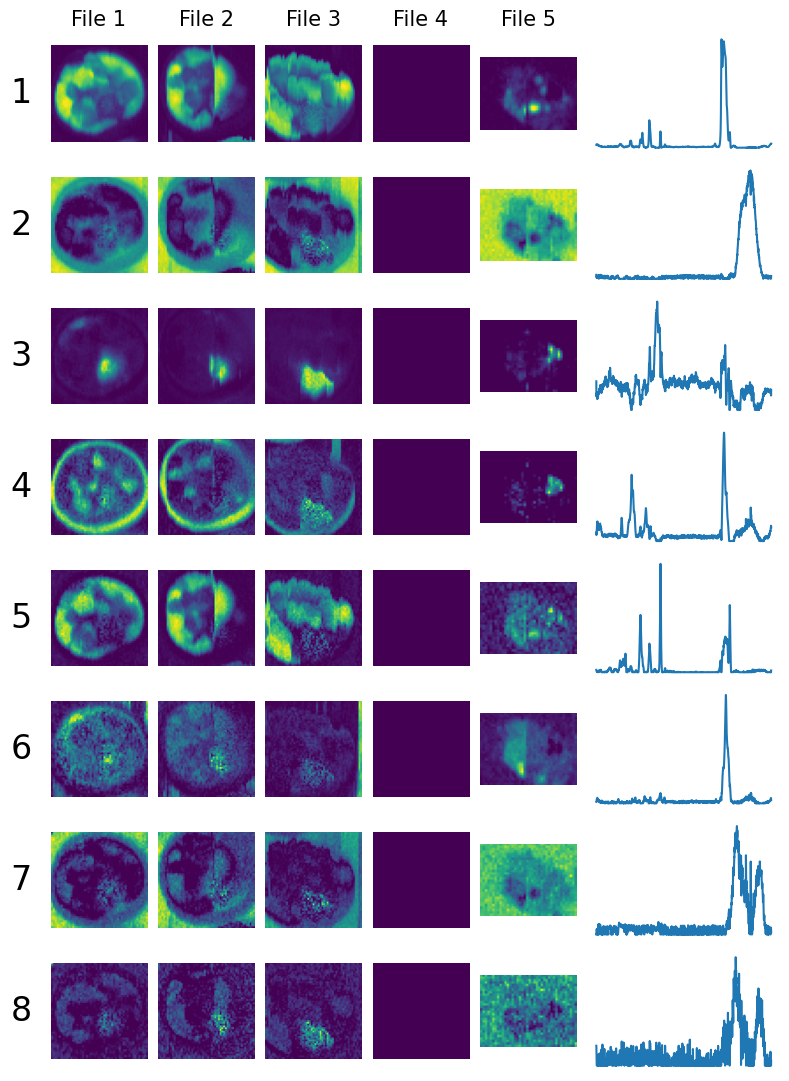

In [143]:
# make one picture that will have N_COMPS rows and 4 columns, first three columns will be the maps, the last one will be the spectrum (component of nmf)

# TODO: make sure that we split the dataset and maps to tuples of five so that we have 5 samples per page

MIN_COMPS = 8
placeholders_to_add = max(MIN_COMPS - N_COMPS, 0)

pdf_filename = 'multiple_plots.pdf'
pdf = PdfPages(pdf_filename)
a4_width_in = 8.27
a4_height_in = 11.69

# Create a figure
fig = plt.figure(figsize=(a4_width_in, a4_height_in))

# Define GridSpec
gs = GridSpec(N_COMPS + placeholders_to_add, len(dataset) + 1, width_ratios=[1] * len(dataset) + [2])

# Add titles above each column
for j in range(len(dataset)):
    ax = fig.add_subplot(gs[0, j])
    ax.set_title(f'File {j + 1}', fontsize=15)
    ax.axis('off')  # Hide axis for title cells

# Set row labels and plot images
for i in range(N_COMPS):
    ax = fig.add_subplot(gs[i, 0])
    ax.text(-0.2, 0.5, f'{i + 1}', va='center', ha='right', fontsize=24, transform=ax.transAxes)
    ax.axis('off')  # Hide axis for row label cells

    for j, map in enumerate(maps):
        ax = fig.add_subplot(gs[i, j])
        img = map[:, :, i]
        ax.imshow(img)
        ax.axis('off')  # Hide axis for image cells

    ax = fig.add_subplot(gs[i, -1])
    ax.plot(new_x_axis, nmf.components_[i])
    ax.axis('off')  # Hide axis for component spectrum cells

for i in range(placeholders_to_add):
    ax = fig.add_subplot(gs[N_COMPS + i, 0])
    ax.axis('off')  # Hide axis for placeholder cells
    for j, map in enumerate(maps):
        ax = fig.add_subplot(gs[N_COMPS + i, j])
        # make img just white placeholder
        img = np.ones_like(map[:, :, 0])
        ax.imshow(img, cmap='gray_r')
        ax.axis('off')  # Hide axis for image cells
    ax = fig.add_subplot(gs[N_COMPS + i, -1])
    ax.axis('off')  # Hide axis for component spectrum cells

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9, left=0.1)  # Adjust these values to minimize space

pdf.savefig()  # Save the current figure to the PDF
pdf.close()

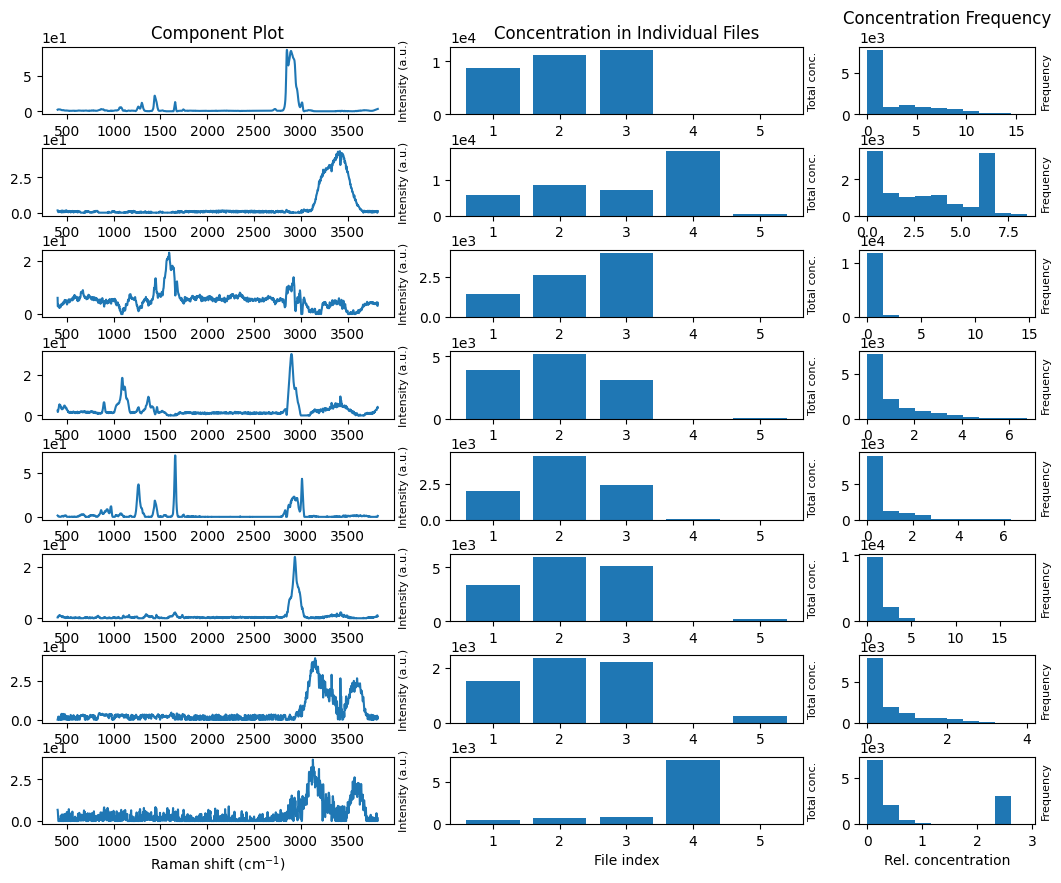

In [146]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# Assuming N_COMPS, dataset, maps, new_x_axis, and nmf are defined

# Compute concentrations
conc = [np.sum(map.reshape((-1, N_COMPS)), axis=0) for map in maps]

# Concatenate all values for the respective component from all files
pixel_conc = [np.concatenate([map[:, :, i].reshape(-1) for map in maps]) for i in range(N_COMPS)]

# Bar plots PDF
pdf_filename_bar = 'concentration_bar_plots.pdf'
pdf_bar = PdfPages(pdf_filename_bar)
a4_width_in = 11.69  # Landscape A4
a4_height_in = 8.27

# Create a figure for the bar plots and component plots
fig_bar = plt.figure(figsize=(a4_width_in, a4_height_in))
gs_bar = GridSpec(N_COMPS + placeholders_to_add, 3, width_ratios=[2, 2, 1])  # Three columns: 1 for bar plot, 1 for component plot, 1 for histogram

# Plot concentration bar plots, component plots, and histograms
for i in range(N_COMPS):
    # Plot the bar plot for concentration
    ax_bar = fig_bar.add_subplot(gs_bar[i, 1])
    ax_bar.bar(list(range(len(dataset))), [c[i] for c in conc])
    ax_bar.set_xticks(list(range(len(dataset))))
    ax_bar.set_xticklabels(list(range(1, len(dataset) + 1)))
    if i == 0:
        ax_bar.set_title("Concentration in Individual Files")
    ax_bar.yaxis.set_label_position("right")
    ax_bar.set_ylabel("Total conc.", fontsize=8)
    ax_bar.ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Use scientific notation for y-axis labels
    

    # Plot the component plot
    ax_comp = fig_bar.add_subplot(gs_bar[i, 0])
    ax_comp.plot(new_x_axis, nmf.components_[i])
    if i == 0:
        ax_comp.set_title("Component Plot")
    ax_comp.set_ylabel("Intensity (a.u.)", fontsize=8)
    ax_comp.ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Use scientific notation for y-axis labels
    ax_comp.yaxis.set_label_position("right")

    # Plot the histogram of relative concentrations
    ax_hist = fig_bar.add_subplot(gs_bar[i, 2])
    hist, bins, _ = ax_hist.hist(pixel_conc[i])
    if i == 0:
        ax_hist.set_title("Concentration Frequency")
    ax_hist.set_ylabel("Frequency",fontsize=8)
    ax_hist.yaxis.set_label_position("right")  # Position the y-axis label on the right side
    ax_hist.ticklabel_format(axis='y', style='sci', scilimits=(0,0))  # Use scientific notation for y-axis labels

    # Add a common ylabel for all rows
    if i == 0:
        ax_hist.set_ylabel("Frequency")
        #ax_hist.yaxis.set_label_coords(1.2, 0.5)  # Adjust position for y-axis title

    if i == N_COMPS - 1:
        ax_bar.set_xlabel("File index")
        ax_hist.set_xlabel("Rel. concentration")
        ax_comp.set_xlabel("Raman shift (cm$^{-1}$)")

for i in range(placeholders_to_add):
    ax_bar = fig_bar.add_subplot(gs_bar[N_COMPS + i, 1])
    ax_bar.axis('off')  # Hide axis for placeholder cells
    ax_comp = fig_bar.add_subplot(gs_bar[N_COMPS + i, 0])
    ax_comp.axis('off')  # Hide axis for placeholder cells
    ax_hist = fig_bar.add_subplot(gs_bar[N_COMPS + i, 2])
    ax_hist.axis('off')  # Hide axis for placeholder cells

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, top=0.95, left=0.1, right=0.95, bottom=0.01)  # Adjust these values to minimize space

pdf_bar.savefig(fig_bar)  # Save the bar plot and component figure to the PDF
pdf_bar.close()
